In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [31]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first().date
most_recent_date

'2017-08-23'

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Convert date to integers to use datetime()
most_recent_date_formatted = most_recent_date.split('-')
most_recent_year = int(most_recent_date_formatted[0])
most_recent_month = int(most_recent_date_formatted[1])
most_recent_day = int(most_recent_date_formatted[2])

# Calculate the date one year from the last date in data set and convert to string
year_ago = dt.datetime(most_recent_year, most_recent_month, most_recent_day) - dt.timedelta(days=365)
year_ago_str = year_ago.strftime('%Y-%m-%d')
year_ago_str


# Perform a query to retrieve the data and precipitation scores
precipitation_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_str, Measurement.date <= most_recent_date).\
    all()

# # Get date and prcp into lists
all_dates = [date.date for date in precipitation_results]
all_prcp = [rain.prcp for rain in precipitation_results]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(
    {
        'Date': all_dates, 
        'Precipitation': all_prcp
    }
    )

# Sort the dataframe by date
precipitation_df.sort_values("Date", ascending=True, inplace=True)

precipitation_df


,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


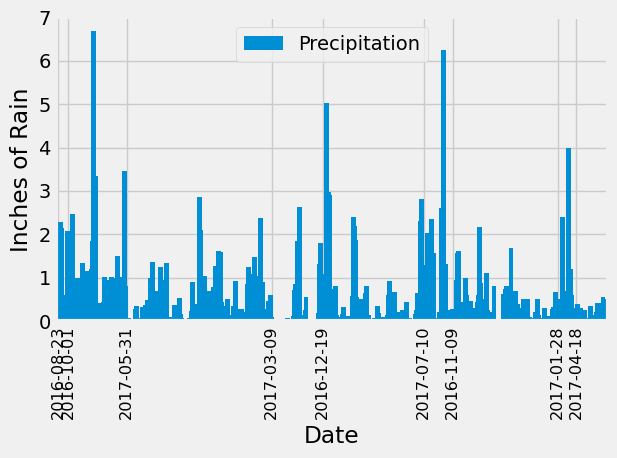

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
selected_dates = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']
selected_indices = [precipitation_df.index[precipitation_df['Date'] == date].tolist()[0] for date in selected_dates]

fig, ax = plt.subplots()
precipitation_df.plot(kind='bar', x='Date', y='Precipitation', ax=ax, legend=True, width=20)


plt.xlabel("Date")
plt.ylabel("Inches of Rain")
plt.ylim(0, 7)

plt.xticks(selected_indices, labels=selected_dates, rotation=90, fontsize='small')

plt.tight_layout()
plt.show()

In [37]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Measurement).group_by(Measurement.station).count()
station_count

9

In [39]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).\
        label('measurement_count')).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
most_active_stats

[(54.0, 85.0, 71.66378066378067)]

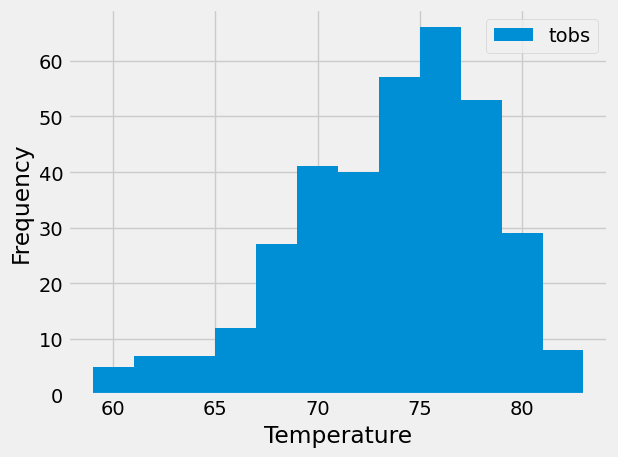

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago_str, Measurement.date <= most_recent_date).\
    all()

    
temps_list = [row[0] for row in most_active_station]

most_active_df = pd.DataFrame(
    {
        'Temperature': temps_list
    }
)

most_active_df['Temperature'].hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()


# Close Session

In [24]:
# Close Session
session.close()